# Diseaseome Data General Analysis and Visualizations

### Import neccesary libraries

In [2]:
import networkx as nx
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
from random import randint
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
#https://www.pnas.org/content/104/21/8685/tab-figures-data

### General Network Analysis Function Definitions

In [3]:
### GENERAL NETWORK ANALYSIS FUNCTIONS

def plotDegsCCDF(Go): #Plots CCDF of degrees given a network
    degrees = Go.degree()
    kmax    = 0
    kis     = []
    # tabulate and display the CCDF Pr(K>=k)
    for _,ki in degrees:
        kis.append(ki)
        if ki > kmax: kmax = ki

    counts, bins = np.histogram(kis, bins=[i for i in range(kmax+2)], density=True)
    cumcounts = np.cumsum(counts)
    cumcounts = np.insert(cumcounts,0,0)
    plt.loglog(bins[1:-1], 1-cumcounts[1:-1], 'rs', alpha=0.5)
    plt.xlabel('Degree, k')
    plt.ylabel('Pr(K>=k)')
    plt.show()
    return

def calculateMeanGeodesic(Go):
    n = Go.number_of_nodes()#function for number of nodes
    m = Go.size() #function for number of edges

    dij = dict(nx.all_pairs_shortest_path_length(Go)) # APSP on G, store as a dictionary (tricky :)
    mean_geo_path_per_Node = [] # store average path length from any given nodes
    for i in dij.values(): #iterate through each dict of shortest pathes per node
        node = []
        for x in i.values(): #iterate through shortest pathes for each node
            if x != 0: # if path length doesn't equal zero then append to shortest pathes
                node.append(x)
        if len(node)!=0: #if node has any nodes attached then find the mean shortest path and add to list of all nodes
            mean_geo_path_per_Node.append(np.mean(node))
    ellmean = np.mean(mean_geo_path_per_Node)#add mean of graph to ellms array
    return ellmean

def summaryStats(Go, bipartite = True):
    n = Go.number_of_nodes()#function for number of nodes
    m = Go.size() #function for number of edges
    kmean = m*2/n #mean of in directed degree is edges/number of nodes
    ellmean = calculateMeanGeodesic(Go)

    print(f'number of nodes, n  = {n}')
    print(f'number of edges, m  = {m}')
    print(f'mean degree,    <k> = %5.2f' % kmean)
    print(f'mean geodesic distance, <ell> = %5.2f' % ellmean)
    if not bipartite:
        C = nx.transitivity(Go)# C 
        print(f'clustering coefficient, C     = %5.2f' % C)

### Network Editing  Function Definitions

In [4]:
# CUSTOM FUNCTIONS FOR DISEASOME DATA 

# seperateType: takes a bipartite network and takes projects it given a type ('gene' or 'disease' in our case)
def seperateType(Go, IsolateType): # seperate bipartite graph into projections
    G_new = nx.Graph() #make new graph
    
    for i in Go.nodes(): #create edge between i and p, where p is the nodes that i -> other group -> p
        if Go.node[i]['Type'] == IsolateType: #if type we want
            
            neighbors = list(Go.neighbors(i))#make list of neighbors
            compression = len(neighbors)#store the amount of original neighbors and store as attribute
            G_new.add_node(i, Type = Go.node[i]['Type'], Class = Go.node[i]['Class'], 
                                                           Compressed_Neighbors = compression)
            add = {} #before adding second neighbors store the amount of shared (genes or diseases)
            
            for neighbor in neighbors: #For each neighbor find second neighbors
                for second_neighbor in list(Go.neighbors(neighbor)):
                    
                    if second_neighbor in add: #already shared gene so increment
                        add[second_neighbor] = add[second_neighbor] + 1
                        
                    else:
                        add[second_neighbor] = 1 #first time seeing this (gene/disease) so add common connections 1
            
            for key, value in add.items(): #now go through and add edges with found wieghts
                if i != key: #No self loops :P
                    G_new.add_edge(i, key, weight = value)
            
    return G_new #return 1-partite graph
    
# removeSingletons: given a graph return a copy of it without the singletons
def removeSingletons(Go): #this function is to make a new graph without singletons located in input graph
    G_new = Go.copy()
    for i in Go.nodes():
        if G_new.degree(i) == 0: #for every node that has degree 0 delete
            G_new.remove_node(i)
    return G_new

# largestComponent
def breadthFirstTraversal(Go, bipartite = True): #return a largest subset graph of GO
    G_new = nx.Graph() #new graph
    
    #find LCC and assume it is contained in largest connected subgraph
    max_i = 0
    max_deg = 0
    for i,j in Go.degree():
        if j > max_deg:
            max_deg = j
            max_i = i
    print("Starting at:", max_i)
    #store explored and unexplored nodes
    unexplored_nodes = [max_i]
    current = unexplored_nodes[0]
    explored_nodes = []
    if not bipartite:
        G_new.add_node(current, Type = Go.node[current]['Type'], Class = Go.node[current]['Class'], Compressed_Neighbors = Go.node[current]['Compressed_Neighbors'])
    else:
        G_new.add_node(current, Type = Go.node[current]['Type'], Class = Go.node[current]['Class'])

    while len(unexplored_nodes) > 0:
        # go to front of queue and explore node 0
        current = unexplored_nodes[0] 
        nieghbors = list(Go.neighbors(current))
        for i in nieghbors:# go through neighbors depthfirst and build subgraph
            if i not in unexplored_nodes and i not in explored_nodes:
                unexplored_nodes.append(i)
                if not bipartite:
                    G_new.add_node(i, Type = Go.node[i]['Type'], Class = Go.node[i]['Class'], Compressed_Neighbors = Go.node[i]['Compressed_Neighbors'])
                else:
                    G_new.add_node(i, Type = Go.node[i]['Type'], Class = Go.node[i]['Class'])
                G_new.add_edge(current, i)
                
        unexplored_nodes.remove(current) #delete from unexplored
        explored_nodes.append(current) #add to explored
                               
    return G_new


### Diseasome Plot/Visualization Function Definition

In [37]:
# plotGraph: layout graph to show structure and imitate https://www.pnas.org/content/104/21/8685
def plotGraph(Graph, ColorBy, bipartite = False, all_connected = False): #node_size = True,
 
    # Initialize figure
    plt.figure(figsize=(15,15))
    
    # Use spring_layout if not connected, this is because kamada will overlap unconnected sections
#     if all_connected:
#         pos = nx.kamada_kawai_layout(Graph)
#     else:
#         pos = nx.spring_layout(Graph, seed = 1, weight = "weight", k= 1/Graph.size()**0.3, iterations = 100)
    
    # Define colors for given category
    if ColorBy == "Type":
        color = {'disease':'#7497bc','gene':'#e78c61'}
        
    elif ColorBy == "Class" :
        color = {'Neurological' : "#e6194B",
                 'Cancer' : "#3cb44b",
                 'Ophthamological' : "#ffe119",
                 'Renal' : "#4363d8",
                 'Metabolic' : "#f58231",
                 'Cardiovascular' : "#911eb4",
                 'Ear,Nose,Throat' : "#42d4f4",
                 'multiple' : "#a9a9a9",
                 'Hematological' : "#bfef45",
                 'Gastrointestinal' : "#fabebe",
                 'Immunological' : "#469990",
                 'Respiratory' : "#e6beff",
                 'Psychiatric' : "#9A6324",
                 'Connective tissue disorder' : "#fffac8",
                 'Muscular' : "#800000",
                 'Nutritional' : "#aaffc3",
                 'Dermatological' : "#808000",
                 'Unclassified' : "#DCDCDC",
                 'Endocrine' : "#000075",
                 'Skeletal' : "#f032e6",
                 'Developmental' : "#013220",
                 'Bone' : "#ffd8b1",
                 'Connective tissue' : "#2F4F4F"}


    # segment nodes into their class so plot at the same time with labels for legend
    seg_nodes = {}
    # create dictionary with keys being Class and values being list of nodes in class
    for i in Graph.nodes():
        if Graph.node[i][ColorBy] not in seg_nodes: #if class has yet to be seen
            seg_nodes[Graph.node[i][ColorBy]] = [i]
        else:
            seg_nodes[Graph.node[i][ColorBy]].append(i) #if class is already in dict
    
    edgeColors = []
    for i,j in Graph.edges():
        colori = color[Graph.node[i][ColorBy]]
        colorj = color[Graph.node[j][ColorBy]]
        
        if colori == colorj:
            edgeColors.append(colori)
        else:
            edgeColors.append("#DCDCDC")
            
    if bipartite:
        nx.draw_spring(Graph, node_color = [color[Graph.node[i][ColorBy]] for i in Graph.nodes()],
                            k= 1/Graph.size()**0.3, iterations = 100, seed = 1)
    else:
        nx.draw_spring(Graph, edge_color = edgeColors,node_size = [Graph.node[i]["Compressed_Neighbors"]**1.25+30 for i in Graph.nodes()], node_color = [color[Graph.node[i][ColorBy]] for i in Graph.nodes()],
                            k= 1/Graph.size()**0.3, iterations = 100, seed = 1, weight = "weight")
    
    
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=key,
                          markerfacecolor=value, markersize=15) for key, value in color.items()]
    #plot it
    plt.legend(handles=legend_elements, loc ="best")
    plt.axis('off')
    plt.show()
    

# Omim Data

Create network using Phenotype name as key for node

In [183]:
df_omim = pd.read_csv("Data/morbidmap.txt",sep='\t')

GO = nx.Graph()
for index, row in df_omim.iterrows():
    GO.add_node(row['# Phenotype'], Type='disease')
    for i in row['Gene Symbols'].split(", "):
        if not GO.has_node(i):
            GO.add_node(i, Type = 'gene')
            
        GO.add_edge(row['# Phenotype'], i)

In [11]:
df_omim.head()

# Phenotype  \
0       17,20-lyase deficiency, isolated, 202110 (3)   
1  17-alpha-hydroxylase/17,20-lyase deficiency, 2...   
2     2-aminoadipic 2-oxoadipic aciduria, 204750 (3)   
3              2-methylbutyrylglycinuria, 610006 (3)   
4                         3-M syndrome 1, 273750 (3)   

                      Gene Symbols  MIM Number Cyto Location  
0          CYP17A1, CYP17, P450C17      609300      10q24.32  
1          CYP17A1, CYP17, P450C17      609300      10q24.32  
2  DHTKD1, KIAA1630, AMOXAD, CMT2Q      614984         10p14  
3                    ACADSB, SBCAD      600301      10q26.13  
4                        CUL7, 3M1      609577        6p21.1

In [12]:
summaryStats(GO)

number of nodes, n  = 21733
number of edges, m  = 24398
mean degree,    <k> =  2.25
mean geodesic distance, <ell> =  1.67
clustering coefficient, C     =  0.00


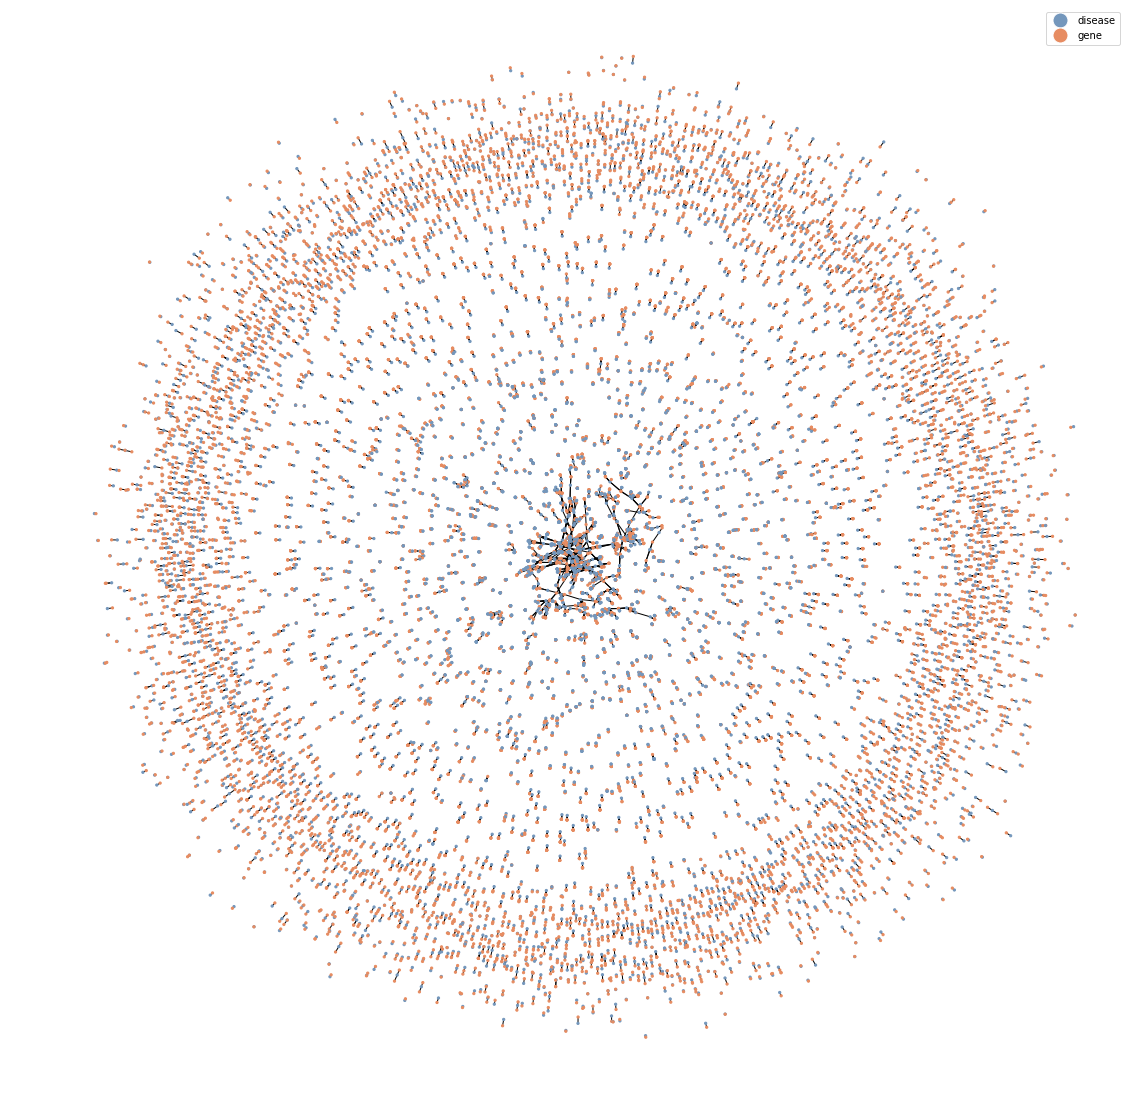

In [17]:
# Initialize figure
plt.figure(figsize=(15,15))
color = {'disease':'#7497bc','gene':'#e78c61'}
nx.draw_spring(GO, node_color = [color[GO.node[i]["Type"]] for i in GO.nodes()], node_size = 5)
legend_elements = [Line2D([0], [0], marker='o', color='w', label=key,
                          markerfacecolor=value, markersize=15) for key, value in color.items()]
plt.legend(handles=legend_elements, loc ="best")
plt.axis('off')
plt.show()

In [18]:
# Retrieve condensed data set

# Spinal muscular atrophy-1, 253300 (3)
# Spinal muscular atrophy-2, 253550 (3)
# Spinal muscular atrophy-3, 253400 (3)
# Spinal muscular atrophy-4, 271150 (3)
# return Spinal muscular atrophy

# Spinocerebellar ataxia 1, 164400 (3)
# Spinocerebellar ataxia 10, 603516 (3)
# Spinocerebellar ataxia 11, 604432 (3)
# Spinocerebellar ataxia 12, 604326 (3)
# return Spinocerebellar ataxia

prev = ""
diseaseNumber = 10000
diseaseList = []

# Classify diseases in groups based on first word in disease name
for index, row in df_omim.iterrows():
    if prev == "":
        prev = row["# Phenotype"].split(" ")
        diseaseList.append(diseaseNumber)
    else:
        current = row["# Phenotype"].split(" ")
        if current[0] == prev[0]:
            diseaseList.append(diseaseNumber)
        else:
            diseaseNumber = diseaseNumber + 1
            diseaseList.append(diseaseNumber)
        prev = current

df_omim["# Disease ID"] = diseaseList

In [19]:
df_omim.head()

# Phenotype  \
0       17,20-lyase deficiency, isolated, 202110 (3)   
1  17-alpha-hydroxylase/17,20-lyase deficiency, 2...   
2     2-aminoadipic 2-oxoadipic aciduria, 204750 (3)   
3              2-methylbutyrylglycinuria, 610006 (3)   
4                         3-M syndrome 1, 273750 (3)   

                      Gene Symbols  MIM Number Cyto Location  # Disease ID  
0          CYP17A1, CYP17, P450C17      609300      10q24.32         10000  
1          CYP17A1, CYP17, P450C17      609300      10q24.32         10001  
2  DHTKD1, KIAA1630, AMOXAD, CMT2Q      614984         10p14         10002  
3                    ACADSB, SBCAD      600301      10q26.13         10003  
4                        CUL7, 3M1      609577        6p21.1         10004

In [20]:
# Recreate Network with key as ID
GO = nx.Graph()
for index, row in df_omim.iterrows():
    if not GO.has_node(row['# Disease ID']):
        GO.add_node(row['# Disease ID'], Type='disease', Disorder = row['# Phenotype'], Class = "")
        
    for i in row['Gene Symbols'].split(", "):
        if not GO.has_node(i):
            GO.add_node(i, Type = 'gene', Class ="")
            
        GO.add_edge(row['# Disease ID'], i)

In [21]:
# Save Network for prediciton Analysis
nx.write_gml(GO, "GeneratedNetworks/mimNetwork.gml")

In [29]:
summaryStats(GO)

number of nodes, n  = 16844
number of edges, m  = 22804
mean degree,    <k> =  2.71
mean geodesic distance, <ell> =  6.39
clustering coefficient, C     =  0.00


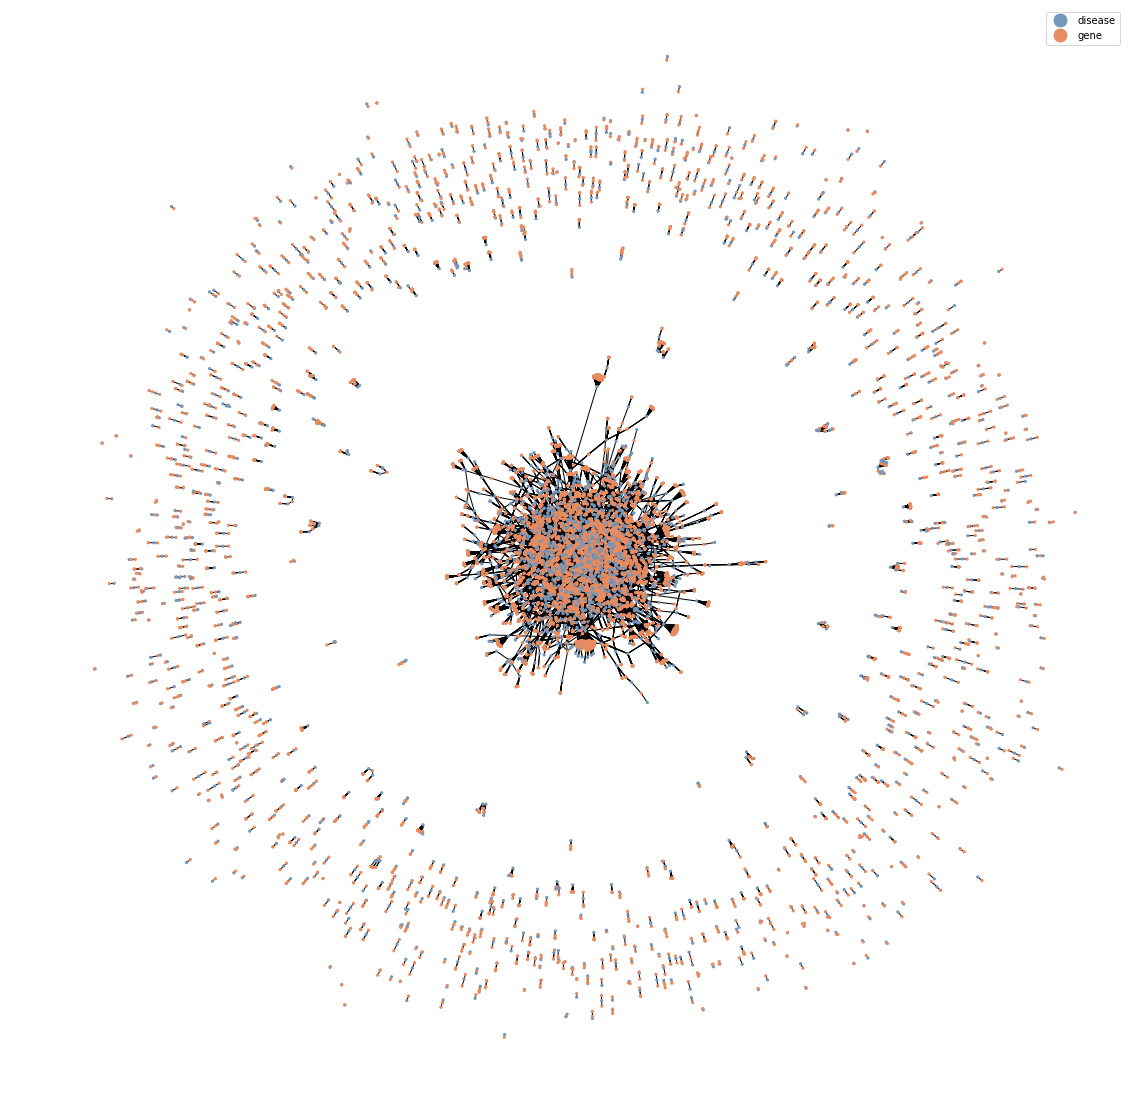

In [30]:
# Initialize figure
plt.figure(figsize=(15,15))
color = {'disease':'#7497bc','gene':'#e78c61'}
nx.draw_spring(GO, node_color = [color[GO.node[i]["Type"]] for i in GO.nodes()], node_size = 5)
legend_elements = [Line2D([0], [0], marker='o', color='w', label=key,
                          markerfacecolor=value, markersize=15) for key, value in color.items()]
plt.legend(handles=legend_elements, loc ="best")
plt.axis('off')
plt.show()

### Omim Gene Projection

In [33]:
# Build Graph
GO_gene = seperateType(GO,'gene')

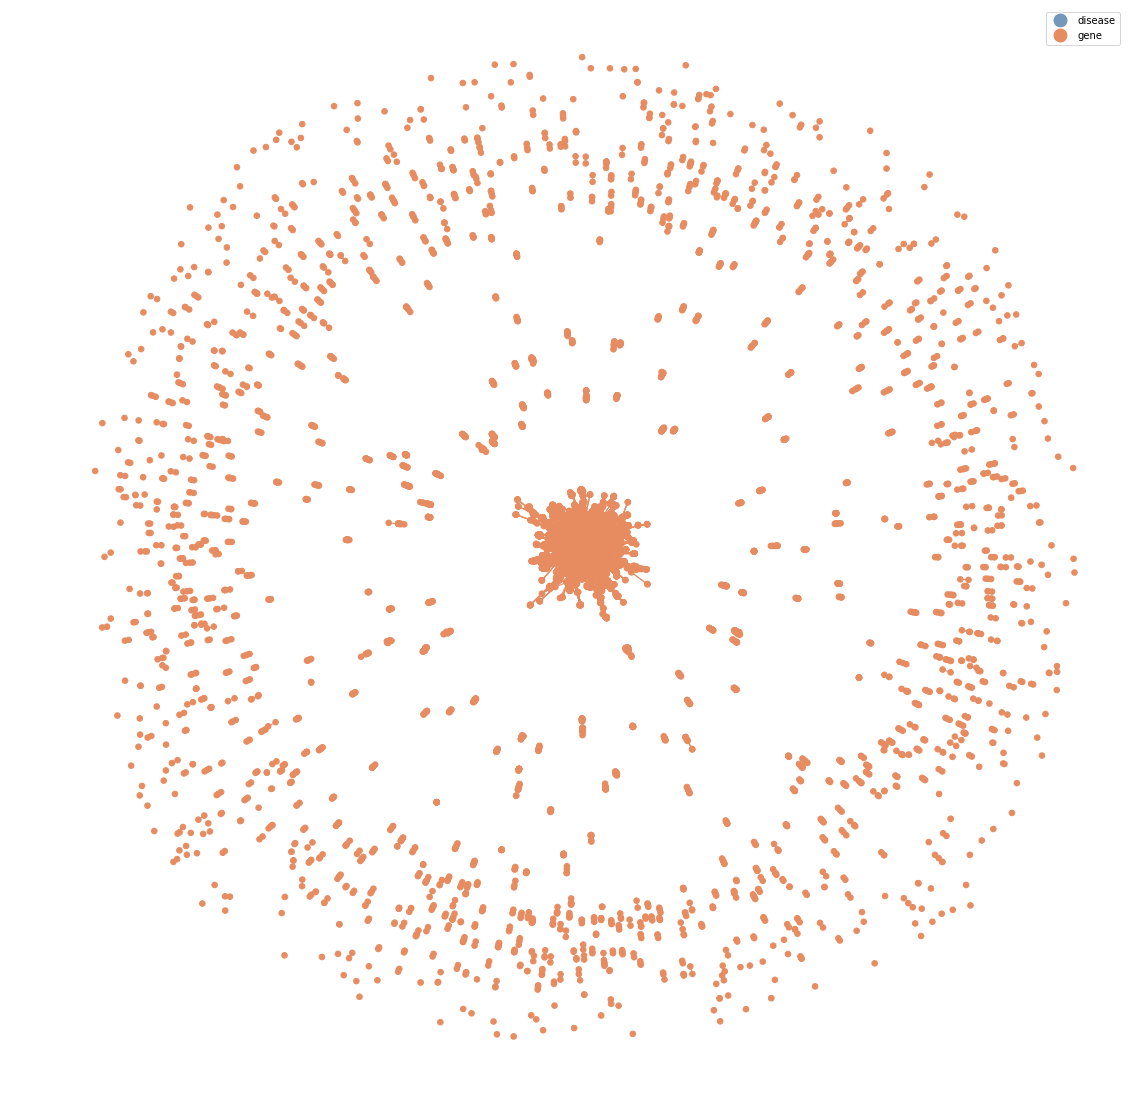

In [86]:
plotGraph(GO_gene,"Type", False)

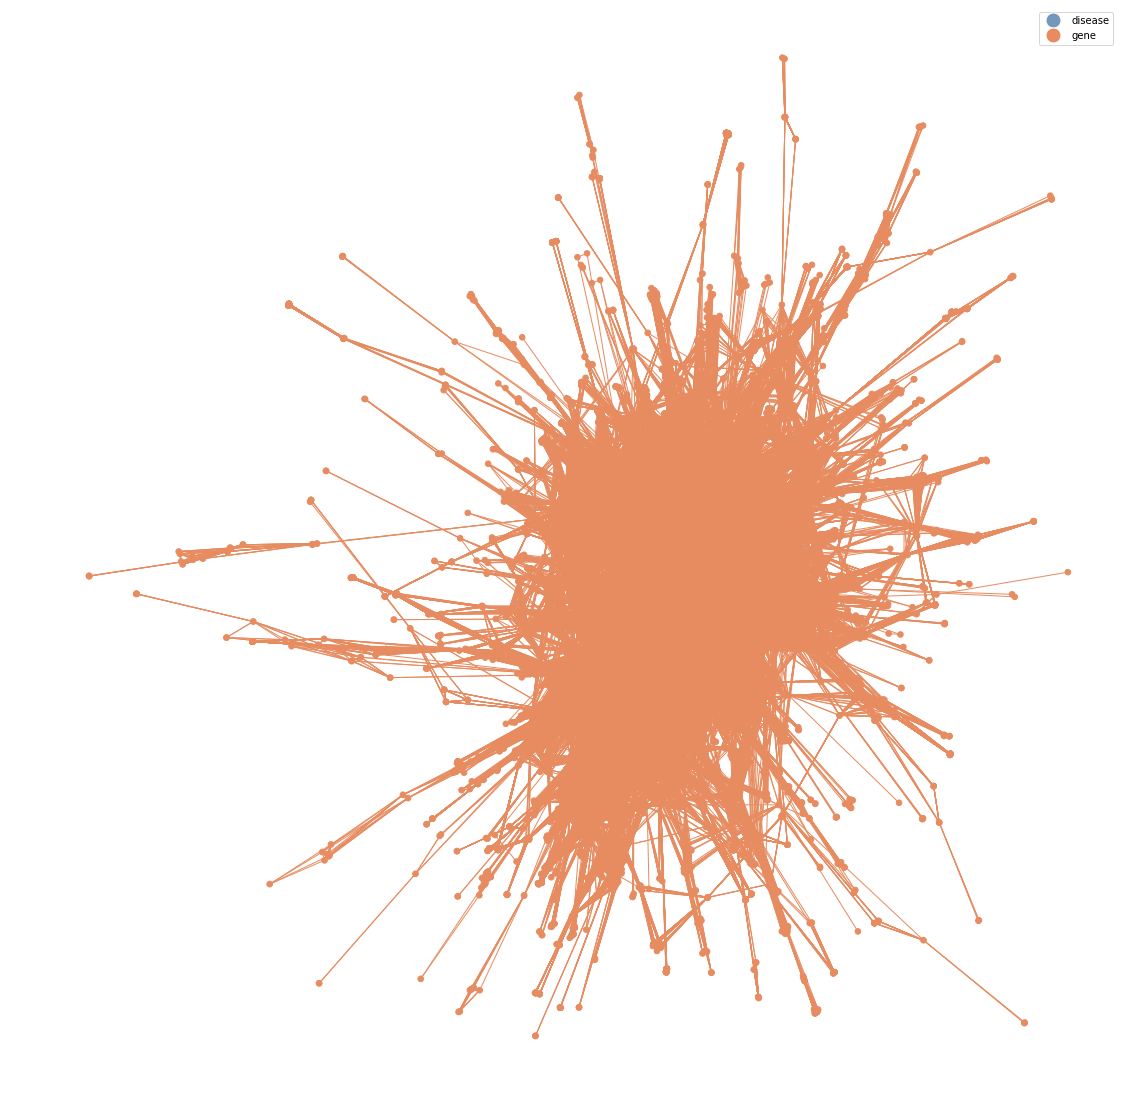

In [87]:
plotGraph(max(nx.connected_component_subgraphs(GO_gene), key=len), "Type")

Starting at: KIF1A


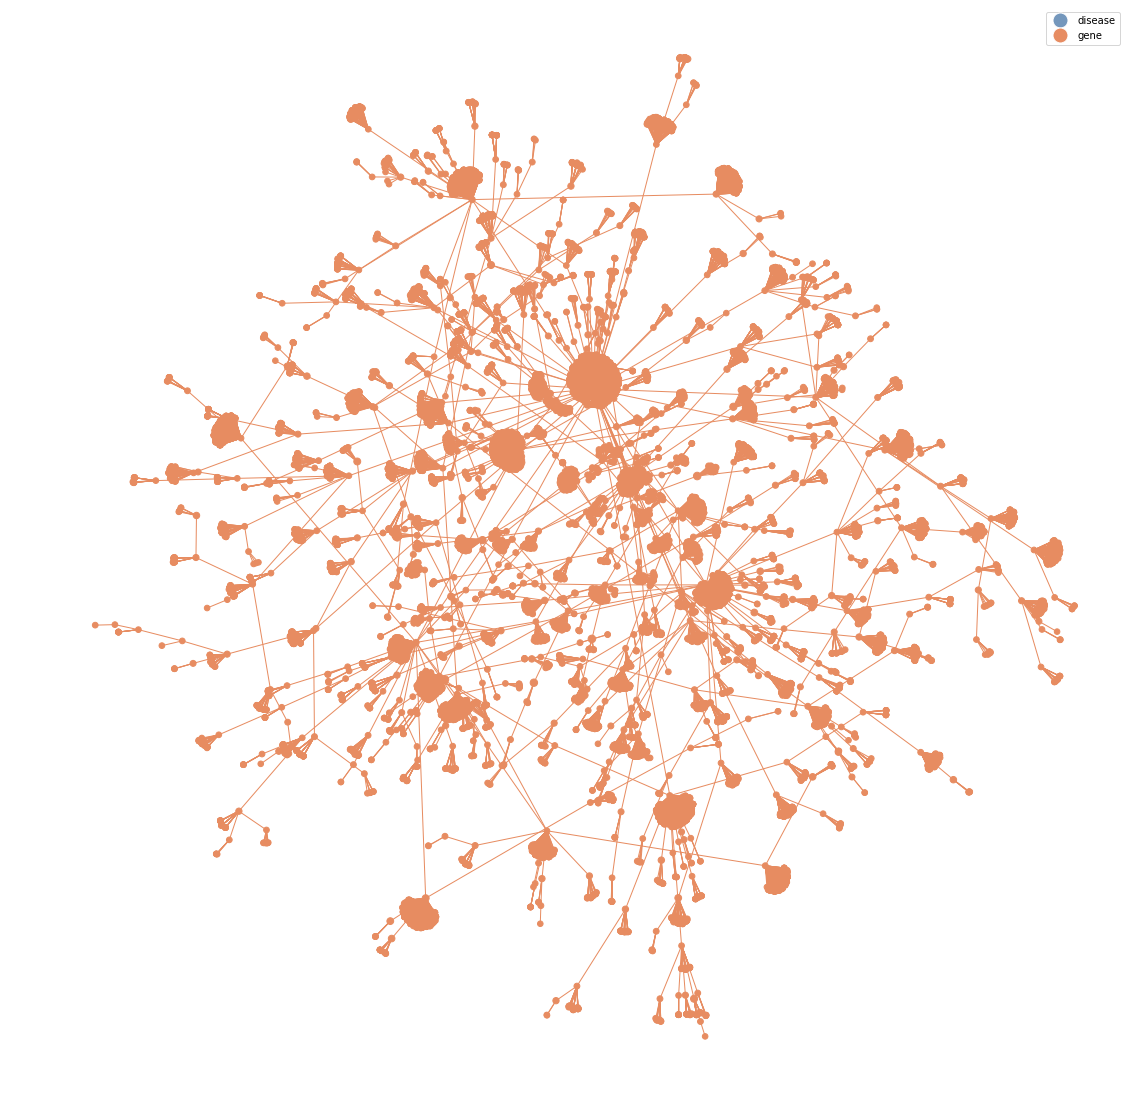

In [90]:
plotGraph(breadthFirstTraversal(GO_gene, False), "Type")

### Omim Disease Projection

In [91]:
# Build Graph
GO_disease = seperateType(GO,'disease')

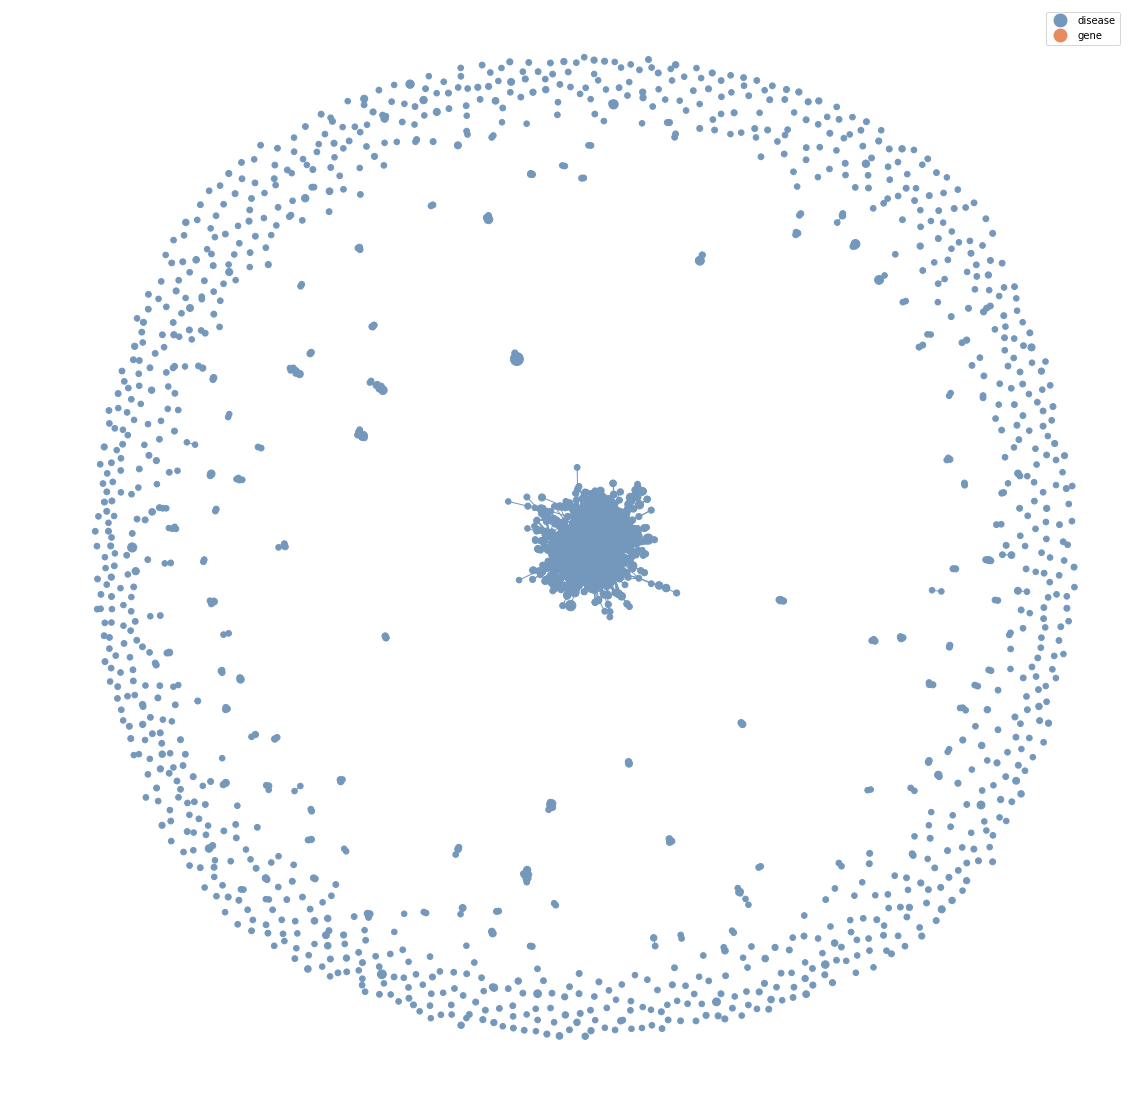

In [92]:
plotGraph(GO_disease,"Type", False)

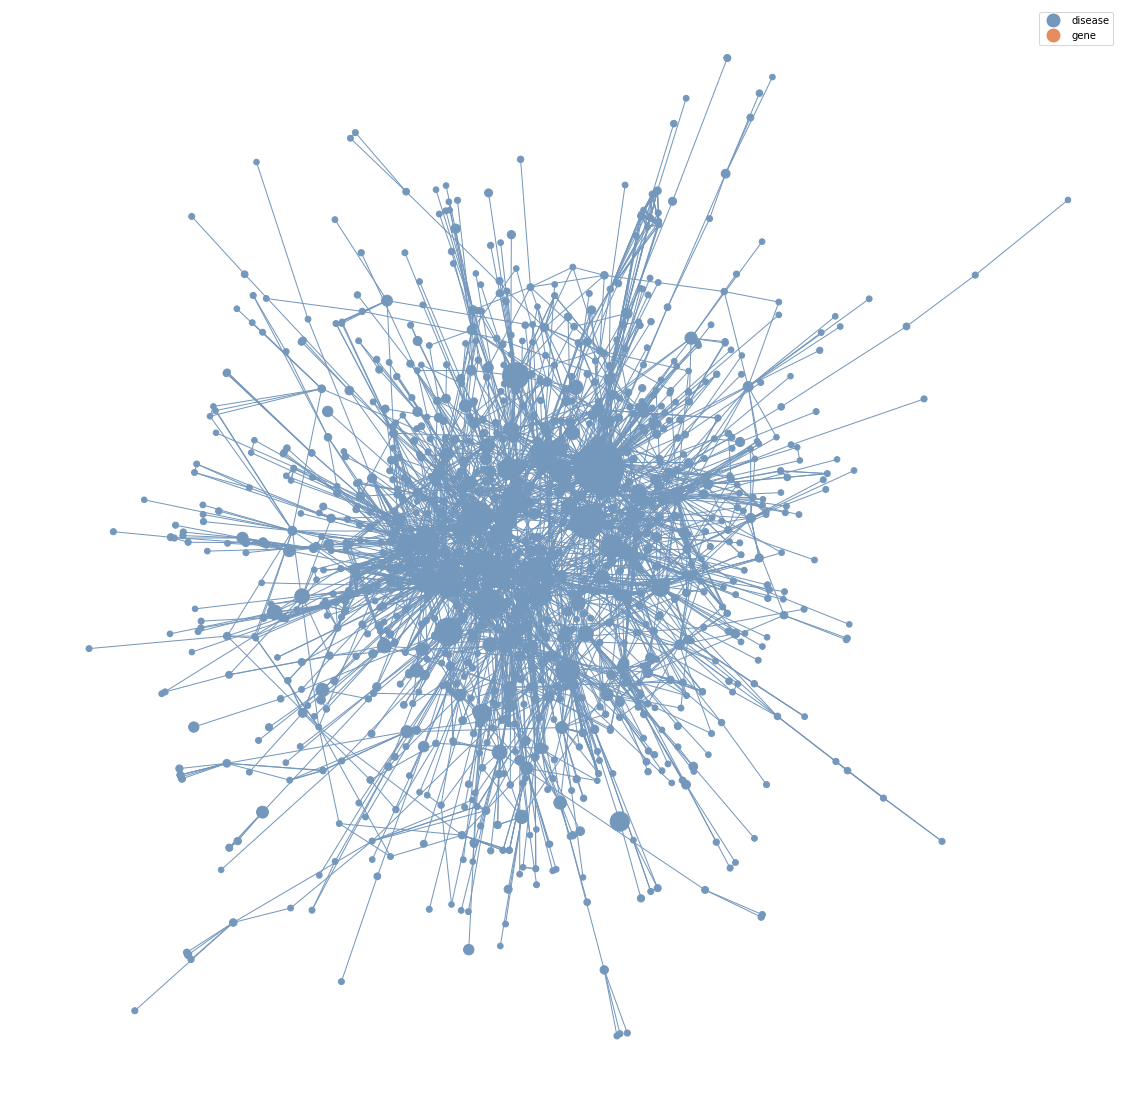

In [93]:
plotGraph(max(nx.connected_component_subgraphs(GO_disease), key=len), "Type")

Starting at: 10676


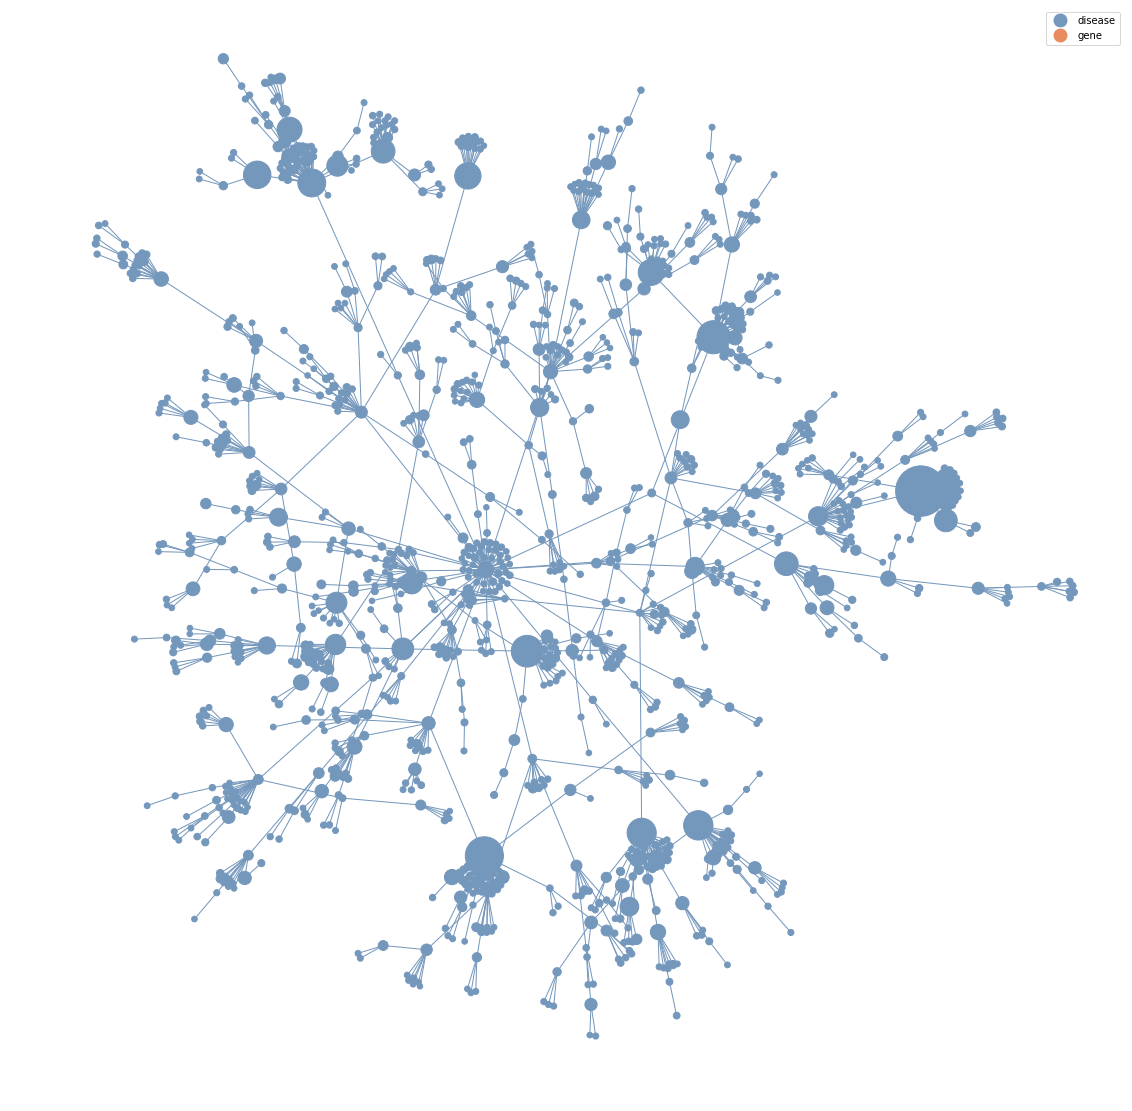

In [94]:
plotGraph(breadthFirstTraversal(GO_disease, False), "Type")

# Diseaseome Data

In [41]:
# read in diseaseome dataset
df = pd.read_csv("Data/Diseaseome.csv",sep=',')
# Retrieved from https://www.pnas.org/content/104/21/8685

G = nx.Graph()
for index, row in df.iterrows():
    if not G.has_node(row['# Disease ID']):
        G.add_node(row['# Disease ID'], Type='disease', Class = row['Class'], Disorder = row['Disorder name'])
        
    for i in row['Gene symbols'].split(", "):
        if not G.has_node(i):
            G.add_node(i, Type = 'gene', Class = row['Class'])
            
        if G.node[i]['Class'] != row['Class']:
            G.node[i]['Class'] = "multiple"
            
        G.add_edge(row['# Disease ID'], i)
        

In [42]:
nx.write_gml(G, "GeneratedNetworks/diseasomeNetwork.gml")

In [43]:
unique_class = list(df["Class"].drop_duplicates())
print(unique_class)

['Neurological', 'Cancer', 'Ophthamological', 'Renal', 'Metabolic', 'Cardiovascular', 'Ear,Nose,Throat', 'multiple', 'Hematological', 'Gastrointestinal', 'Immunological', 'Respiratory', 'Psychiatric', 'Connective tissue disorder', 'Muscular', 'Nutritional', 'Dermatological', 'Unclassified', 'Endocrine', 'Skeletal', 'Developmental', 'Bone', 'Connective tissue']


In [44]:
df.head()

# Disease ID                                      Disorder name  \
0          1428              Spinocerebellar ataxia 14, 605361 (3)   
1          1428  Spinocerebellar ataxia 4, pure Japanese type, ...   
2          1428              Spinocerebellar ataxia-27, 609307 (3)   
3          1428               Spinocerebellar ataxia-6, 183086 (3)   
4          1428              Spinocerebellar ataxia 12, 604326 (3)   

               Gene symbols  OMIM ID Chromosome         Class  2005 Entrez_ID  \
0  PRKCG, PKCC, PKCG, SCA14   176980    19q13.4  Neurological            5582   
1                   PLEKHG4   609526    16q22.1  Neurological           25894   
2        FGF14, FHF4, SCA27   601515      13q34  Neurological            2259   
3   CACNA1A, CACNL1A4, SCA6   601011      19p13  Neurological             773   
4                   PPP2R2B   604325   5q31-q33  Neurological            5521   

  in largest Comp.  i   mu  
0                1  0    0  
1                1  0  542  
2                1  0  548  
3                1  0  583  
4                1  0  799

In [48]:
summaryStats(G)

number of nodes, n  = 5107
number of edges, m  = 6275
mean degree,    <k> =  2.46
mean geodesic distance, <ell> =  7.04


### Bipartite Representation

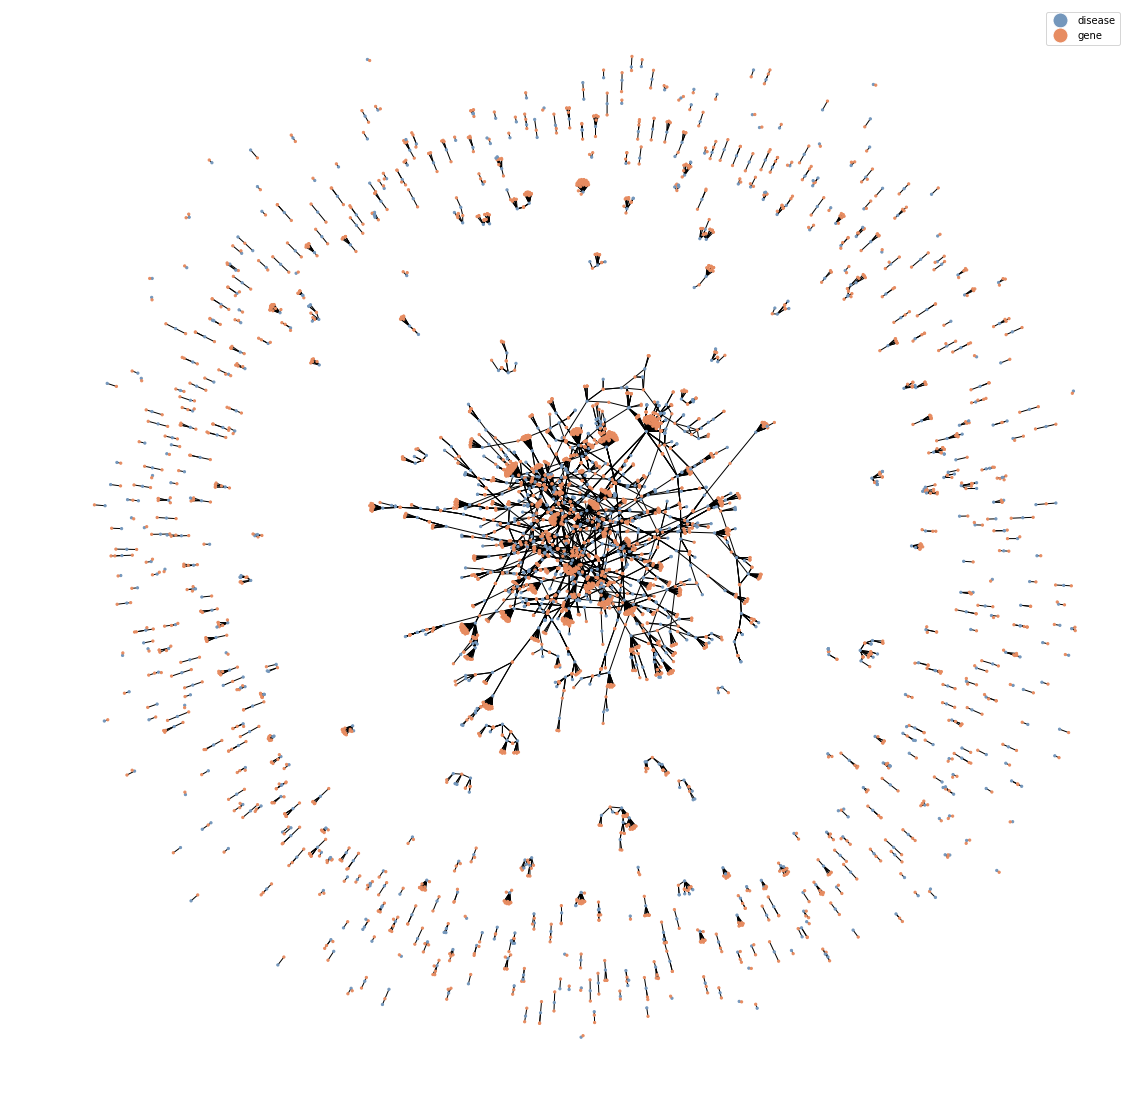

In [45]:
# Initialize figure
plt.figure(figsize=(15,15))
color = {'disease':'#7497bc','gene':'#e78c61'}
nx.draw_spring(G, node_color = [color[G.node[i]["Type"]] for i in G.nodes()], node_size = 5)
legend_elements = [Line2D([0], [0], marker='o', color='w', label=key,
                          markerfacecolor=value, markersize=15) for key, value in color.items()]
plt.legend(handles=legend_elements, loc ="best")
plt.axis('off')
plt.show()

#### Breadth First Representation

Starting at: 406


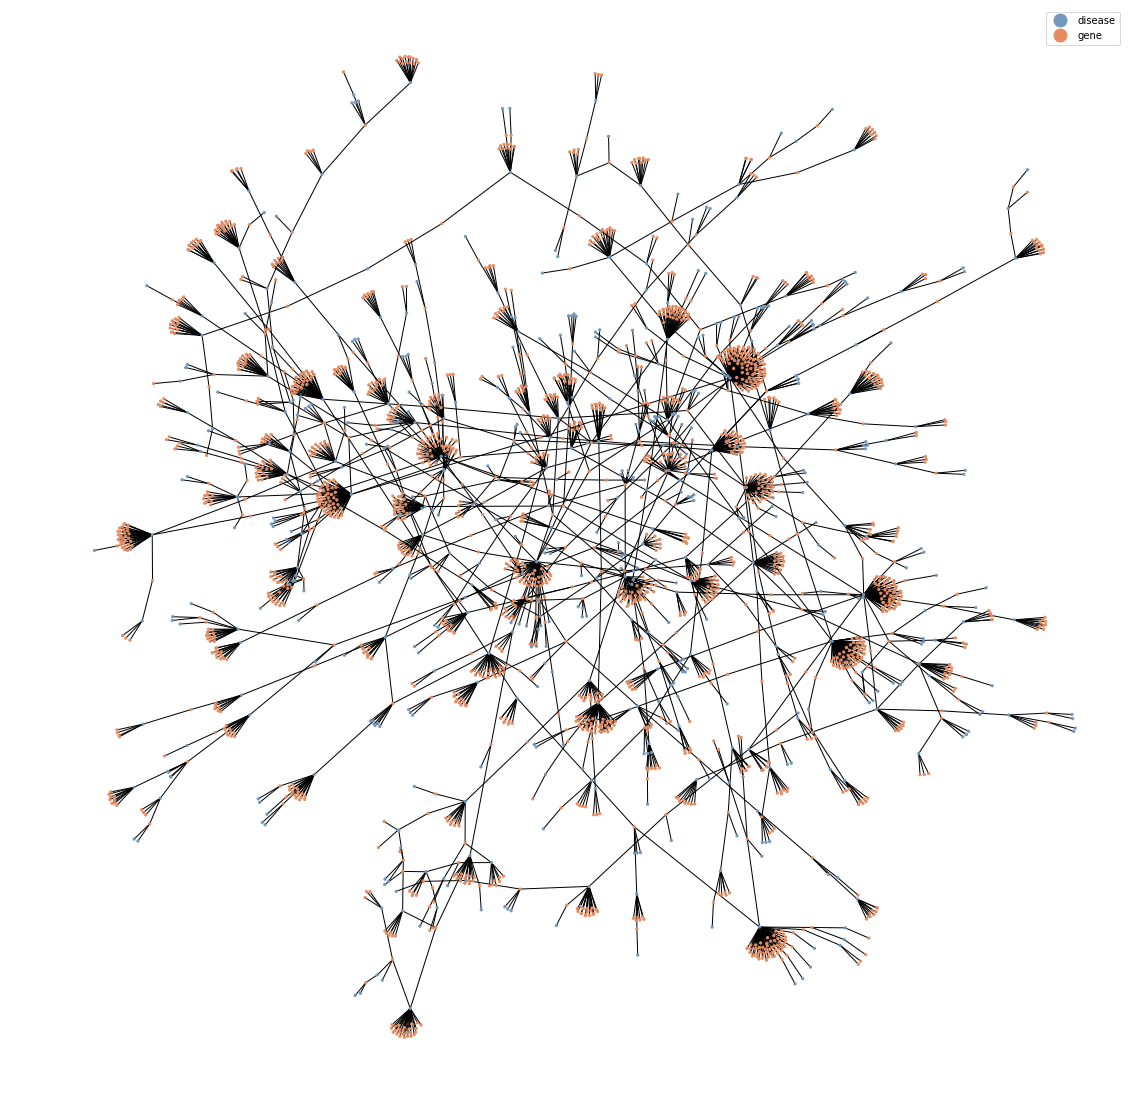

In [51]:
G_bf = breadthFirstTraversal(G, True)

plt.figure(figsize=(15,15))
color = {'disease':'#7497bc','gene':'#e78c61'}
nx.draw_spring(G_bf, node_color = [color[G_bf.node[i]["Type"]] for i in G_bf.nodes()], node_size = 5)
legend_elements = [Line2D([0], [0], marker='o', color='w', label=key,
                          markerfacecolor=value, markersize=15) for key, value in color.items()]
plt.legend(handles=legend_elements, loc ="best")
plt.axis('off')
plt.show()

### Gene Projection

In [52]:
# Build Graph
G_gene = seperateType(G,'gene')

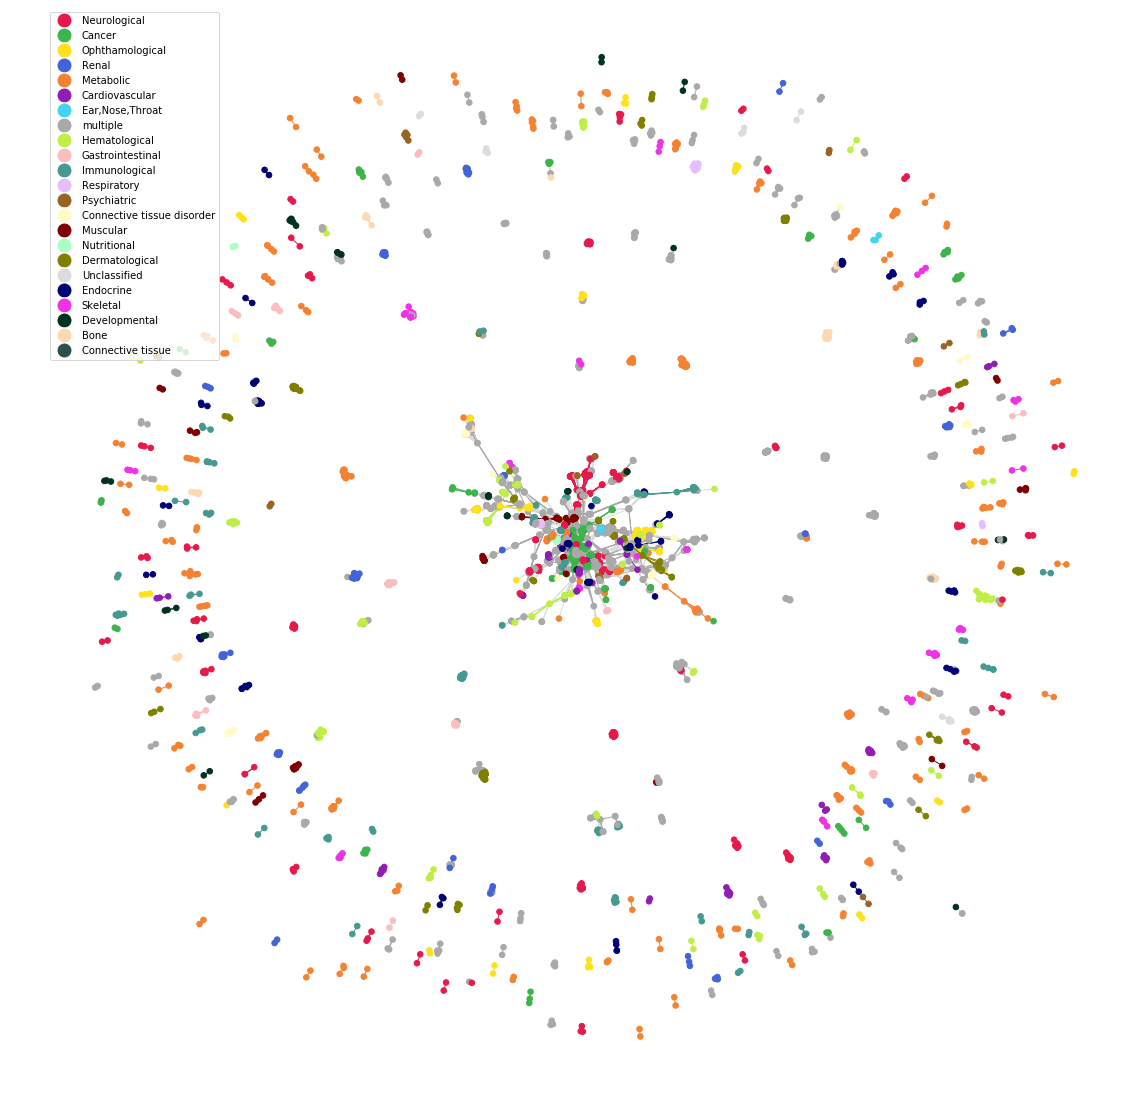

In [73]:
plotGraph(removeSingletons(G_gene), "Class")

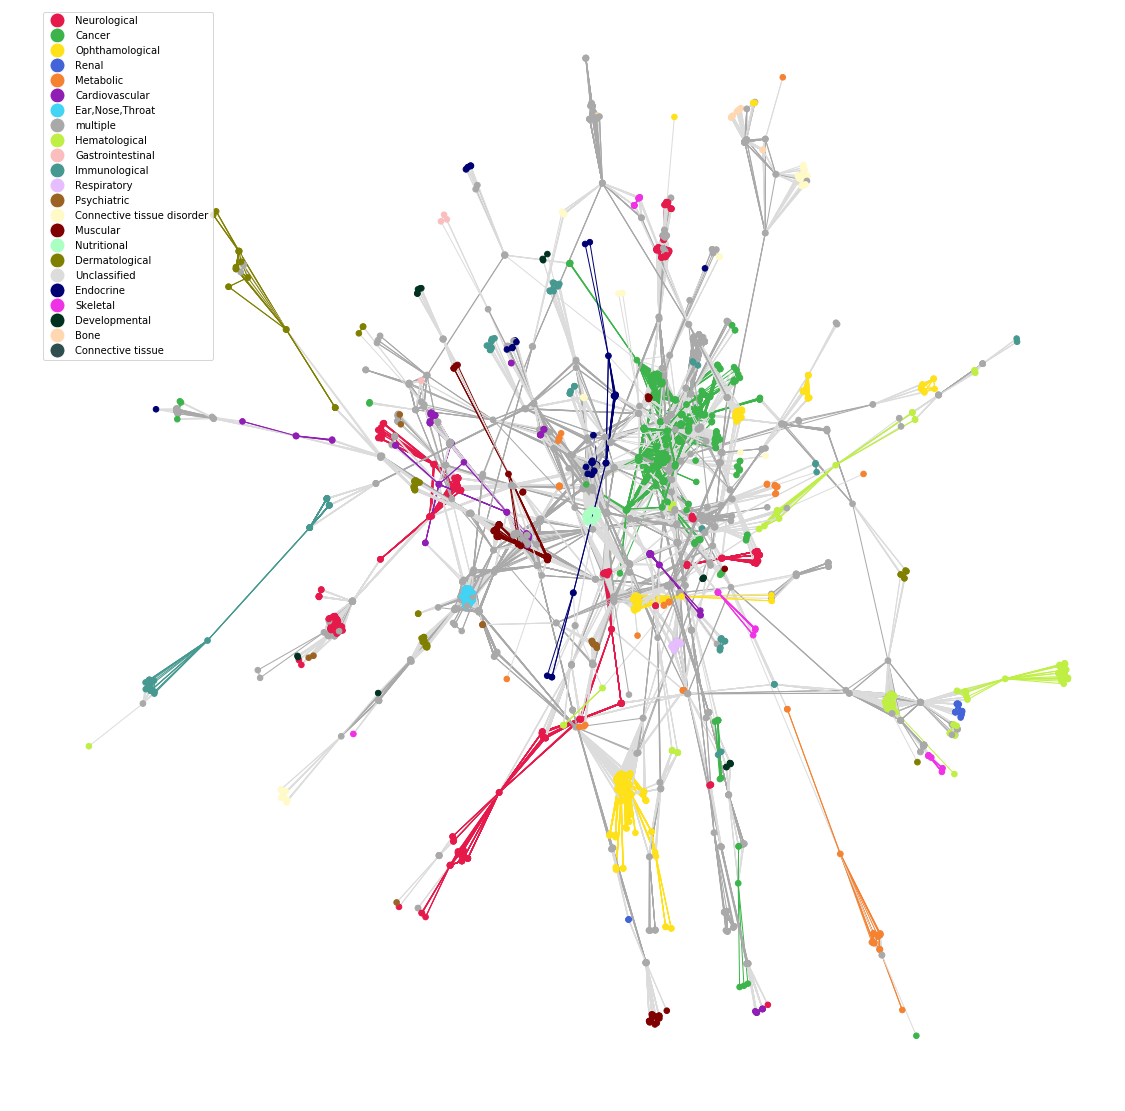

In [53]:
plotGraph(max(nx.connected_component_subgraphs(G_gene), key=len), "Class")

Starting at: EYA4


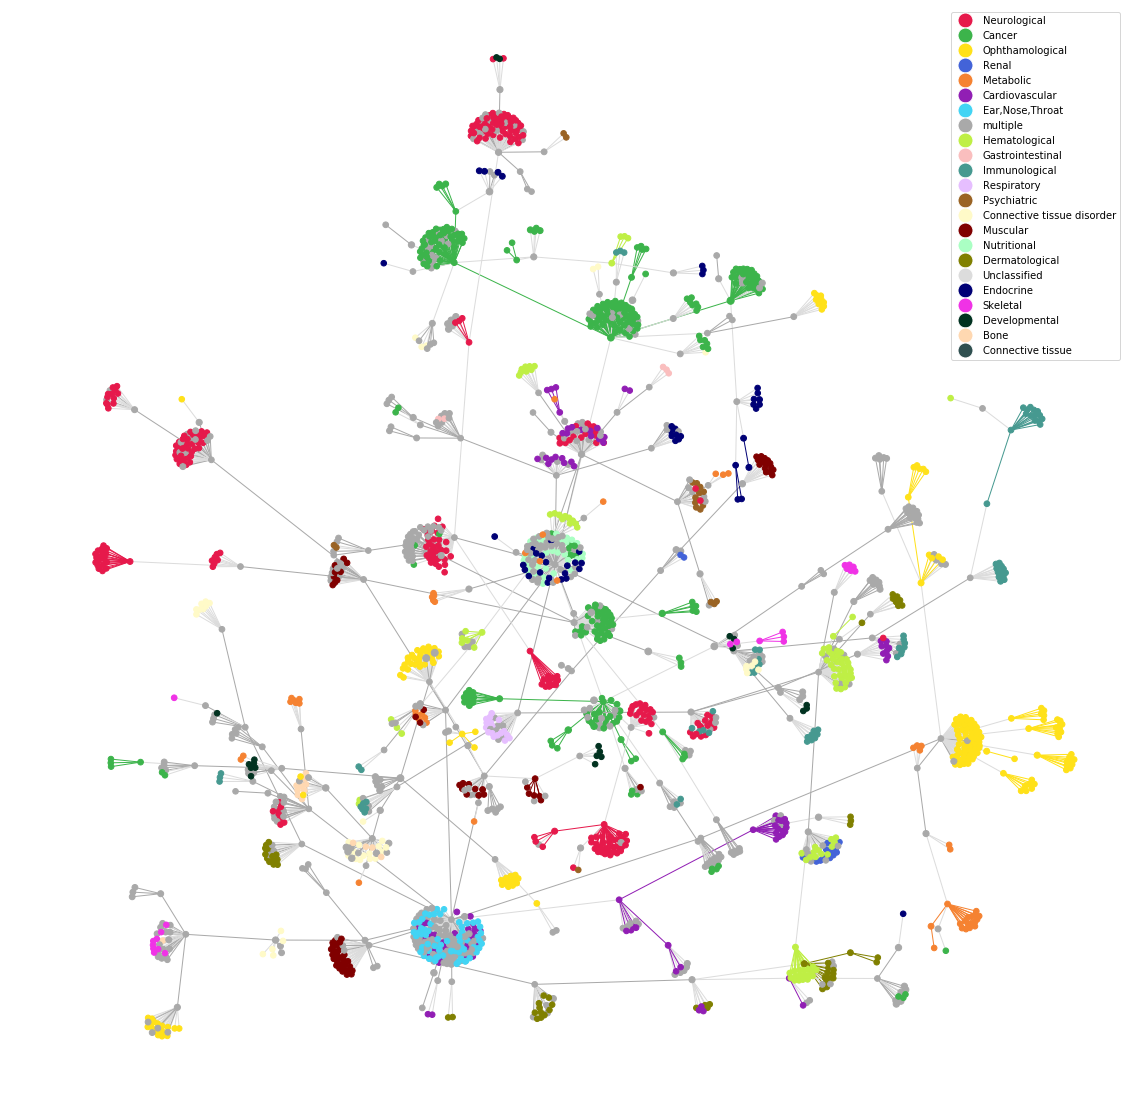

In [55]:
plotGraph(breadthFirstTraversal(G_gene, False), "Class")

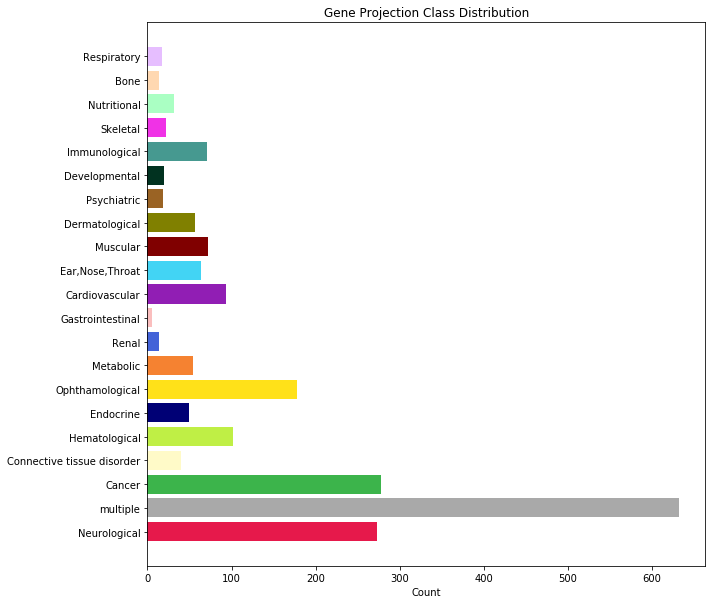

In [181]:
plt.figure(figsize=(10,10))

class_G = max(nx.connected_component_subgraphs(G_gene), key=len)

colors = {'Neurological' : "#e6194B",
         'Cancer' : "#3cb44b",
         'Ophthamological' : "#ffe119",
         'Renal' : "#4363d8",
         'Metabolic' : "#f58231",
         'Cardiovascular' : "#911eb4",
         'Ear,Nose,Throat' : "#42d4f4",
         'multiple' : "#a9a9a9",
         'Hematological' : "#bfef45",
         'Gastrointestinal' : "#fabebe",
         'Immunological' : "#469990",
         'Respiratory' : "#e6beff",
         'Psychiatric' : "#9A6324",
         'Connective tissue disorder' : "#fffac8",
         'Muscular' : "#800000",
         'Nutritional' : "#aaffc3",
         'Dermatological' : "#808000",
         'Unclassified' : "#DCDCDC",
         'Endocrine' : "#000075",
         'Skeletal' : "#f032e6",
         'Developmental' : "#013220",
         'Bone' : "#ffd8b1",
         'Connective tissue' : "#2F4F4F"}
color = []
data = {}
for i in class_G.nodes():
    if class_G.node[i]["Class"] in data:
        data[class_G.node[i]["Class"]] = data[class_G.node[i]["Class"]] + 1
    else:
        data[class_G.node[i]["Class"]] = 1
        color.append(colors[class_G.node[i]["Class"]])

names = list(data.keys())
values = list(data.values())
plt.barh(names, values, color = color)
plt.title("Gene Projection Class Distribution")
plt.xlabel("Count")

plt.show()

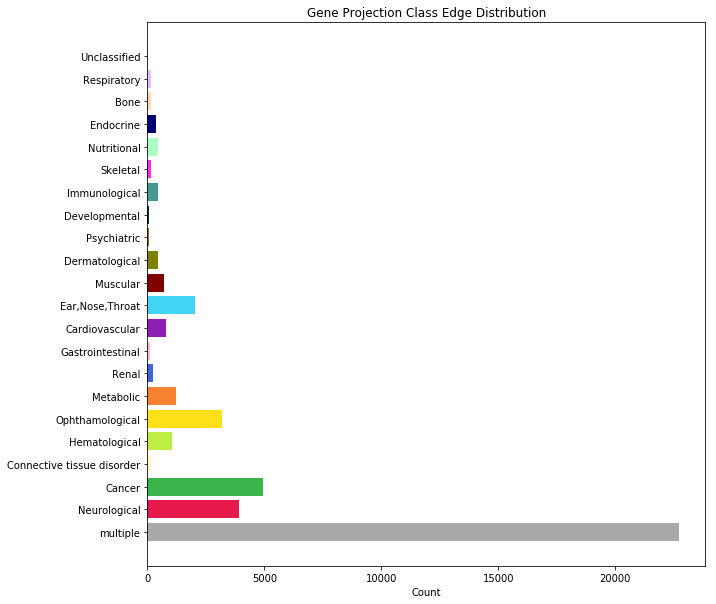

In [172]:
plt.figure(figsize=(10,10))

GT = G_gene

colors = {'Neurological' : "#e6194B",
         'Cancer' : "#3cb44b",
         'Ophthamological' : "#ffe119",
         'Renal' : "#4363d8",
         'Metabolic' : "#f58231",
         'Cardiovascular' : "#911eb4",
         'Ear,Nose,Throat' : "#42d4f4",
         'multiple' : "#a9a9a9",
         'Hematological' : "#bfef45",
         'Gastrointestinal' : "#fabebe",
         'Immunological' : "#469990",
         'Respiratory' : "#e6beff",
         'Psychiatric' : "#9A6324",
         'Connective tissue disorder' : "#fffac8",
         'Muscular' : "#800000",
         'Nutritional' : "#aaffc3",
         'Dermatological' : "#808000",
         'Unclassified' : "#DCDCDC",
         'Endocrine' : "#000075",
         'Skeletal' : "#f032e6",
         'Developmental' : "#013220",
         'Bone' : "#ffd8b1",
         'Connective tissue' : "#2F4F4F"}
color = ["#a9a9a9"]
data = {}
data["multiple"] = 0

for i,j in GT.edges():
    indexi = GT.node[i]["Class"]
    indexj = GT.node[j]["Class"]
    
    if indexi == indexj:
        if indexi in data:
            data[GT.node[i]["Class"]] = data[GT.node[i]["Class"]] + 1
        else:
            data[GT.node[i]["Class"]] = 1
            color.append(colors[GT.node[i]["Class"]])
    else:
        data["multiple"]= data["multiple"] + 1
        
names = list(data.keys())
values = list(data.values())
plt.barh(names, values, color = color)
plt.title("Gene Projection Class Edge Distribution")
plt.xlabel("Count")

plt.show()

### Disease Projection

In [77]:
# Build Graph
G_disease = seperateType(G,'disease')

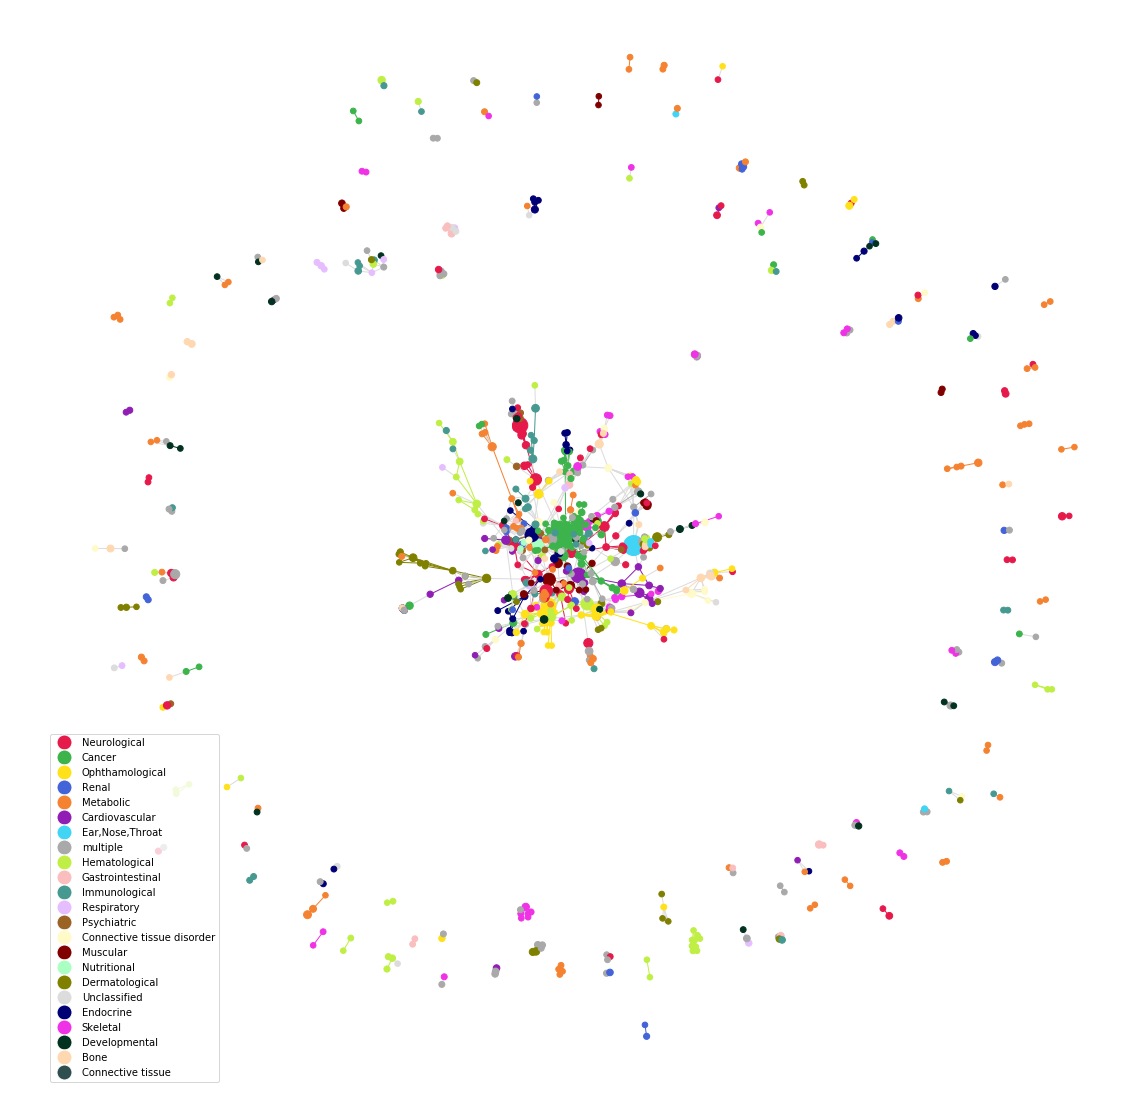

In [78]:
plotGraph(removeSingletons(G_disease),"Class")

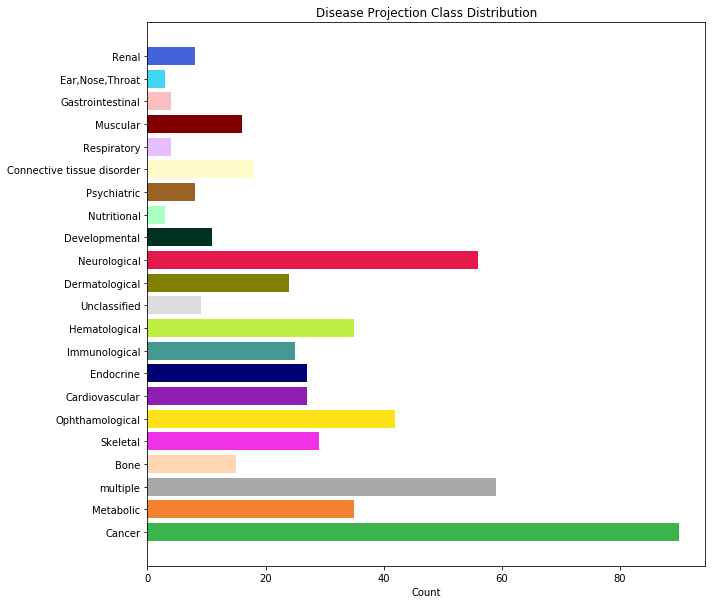

In [179]:
plt.figure(figsize=(10,10))

class_G = max(nx.connected_component_subgraphs(G_disease), key=len)

colors = {'Neurological' : "#e6194B",
         'Cancer' : "#3cb44b",
         'Ophthamological' : "#ffe119",
         'Renal' : "#4363d8",
         'Metabolic' : "#f58231",
         'Cardiovascular' : "#911eb4",
         'Ear,Nose,Throat' : "#42d4f4",
         'multiple' : "#a9a9a9",
         'Hematological' : "#bfef45",
         'Gastrointestinal' : "#fabebe",
         'Immunological' : "#469990",
         'Respiratory' : "#e6beff",
         'Psychiatric' : "#9A6324",
         'Connective tissue disorder' : "#fffac8",
         'Muscular' : "#800000",
         'Nutritional' : "#aaffc3",
         'Dermatological' : "#808000",
         'Unclassified' : "#DCDCDC",
         'Endocrine' : "#000075",
         'Skeletal' : "#f032e6",
         'Developmental' : "#013220",
         'Bone' : "#ffd8b1",
         'Connective tissue' : "#2F4F4F"}
color = []
data = {}
for i in class_G.nodes():
    if class_G.node[i]["Class"] in data:
        data[class_G.node[i]["Class"]] = data[class_G.node[i]["Class"]] + 1
    else:
        data[class_G.node[i]["Class"]] = 1
        color.append(colors[class_G.node[i]["Class"]])

names = list(data.keys())
values = list(data.values())
plt.barh(names, values, color = color)
plt.title("Disease Projection Class Distribution")
plt.xlabel("Count")

plt.show()

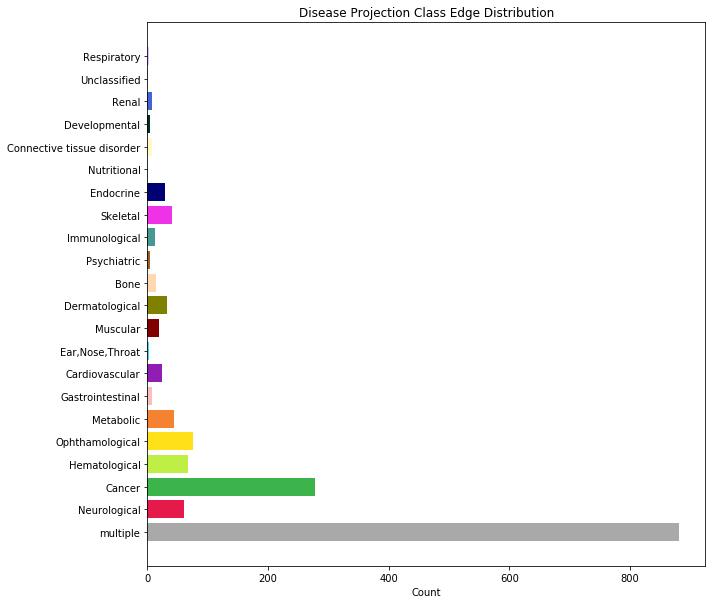

In [180]:
plt.figure(figsize=(10,10))

GT = G_disease

colors = {'Neurological' : "#e6194B",
         'Cancer' : "#3cb44b",
         'Ophthamological' : "#ffe119",
         'Renal' : "#4363d8",
         'Metabolic' : "#f58231",
         'Cardiovascular' : "#911eb4",
         'Ear,Nose,Throat' : "#42d4f4",
         'multiple' : "#a9a9a9",
         'Hematological' : "#bfef45",
         'Gastrointestinal' : "#fabebe",
         'Immunological' : "#469990",
         'Respiratory' : "#e6beff",
         'Psychiatric' : "#9A6324",
         'Connective tissue disorder' : "#fffac8",
         'Muscular' : "#800000",
         'Nutritional' : "#aaffc3",
         'Dermatological' : "#808000",
         'Unclassified' : "#DCDCDC",
         'Endocrine' : "#000075",
         'Skeletal' : "#f032e6",
         'Developmental' : "#013220",
         'Bone' : "#ffd8b1",
         'Connective tissue' : "#2F4F4F"}
color = ["#a9a9a9"]
data = {}
data["multiple"] = 0

for i,j in GT.edges():
    indexi = GT.node[i]["Class"]
    indexj = GT.node[j]["Class"]
    
    if indexi == indexj:
        if indexi in data:
            data[GT.node[i]["Class"]] = data[GT.node[i]["Class"]] + 1
        else:
            data[GT.node[i]["Class"]] = 1
            color.append(colors[GT.node[i]["Class"]])
    else:
        data["multiple"]= data["multiple"] + 1
        
names = list(data.keys())
values = list(data.values())
plt.barh(names, values, color = color)
plt.title("Disease Projection Class Edge Distribution")
plt.xlabel("Count")

plt.show()

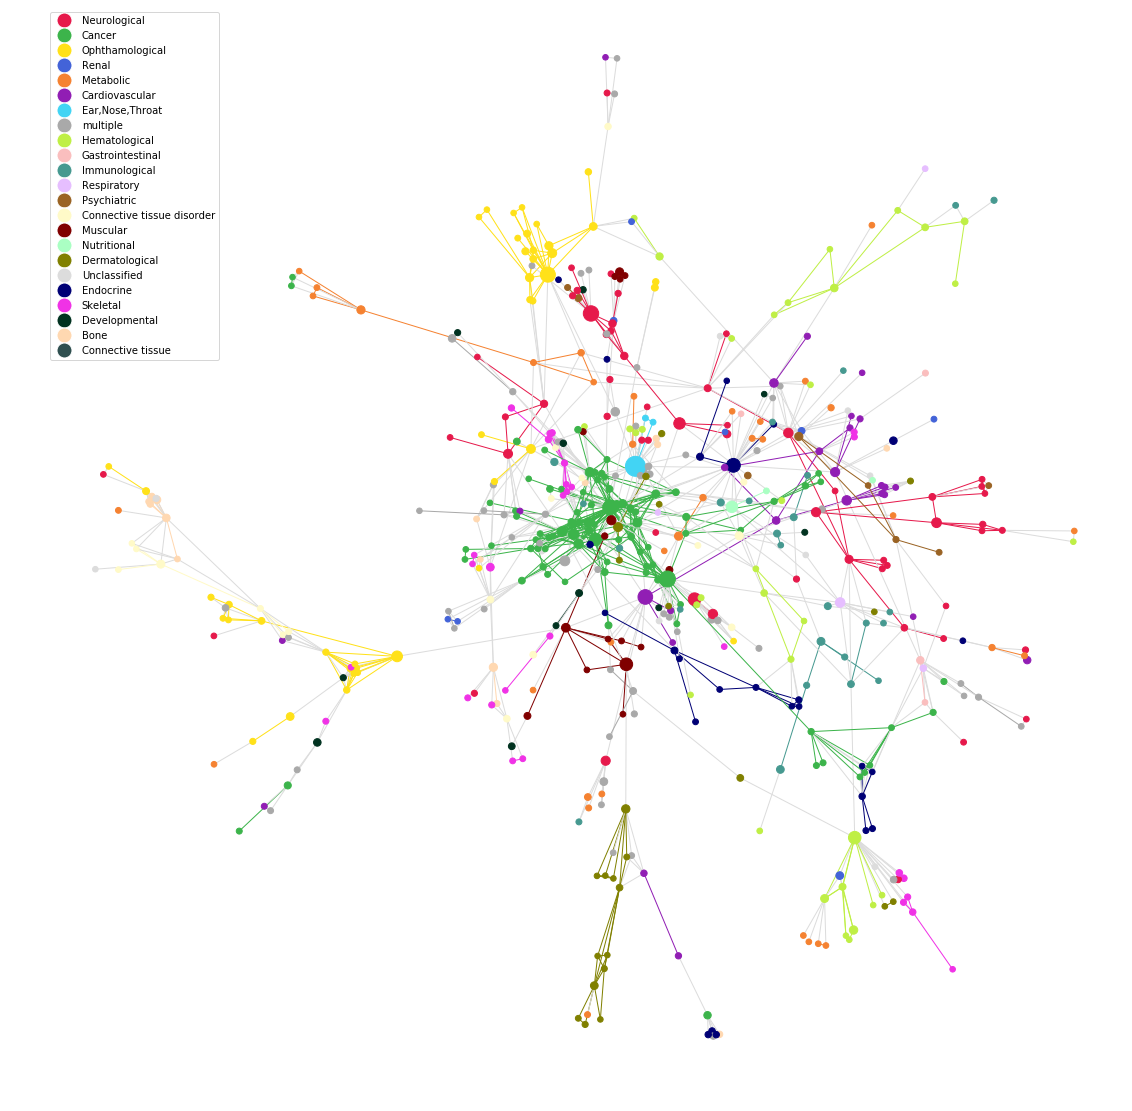

In [176]:
plotGraph(max(nx.connected_component_subgraphs(G_disease), key=len), "Class")

Starting at: 346


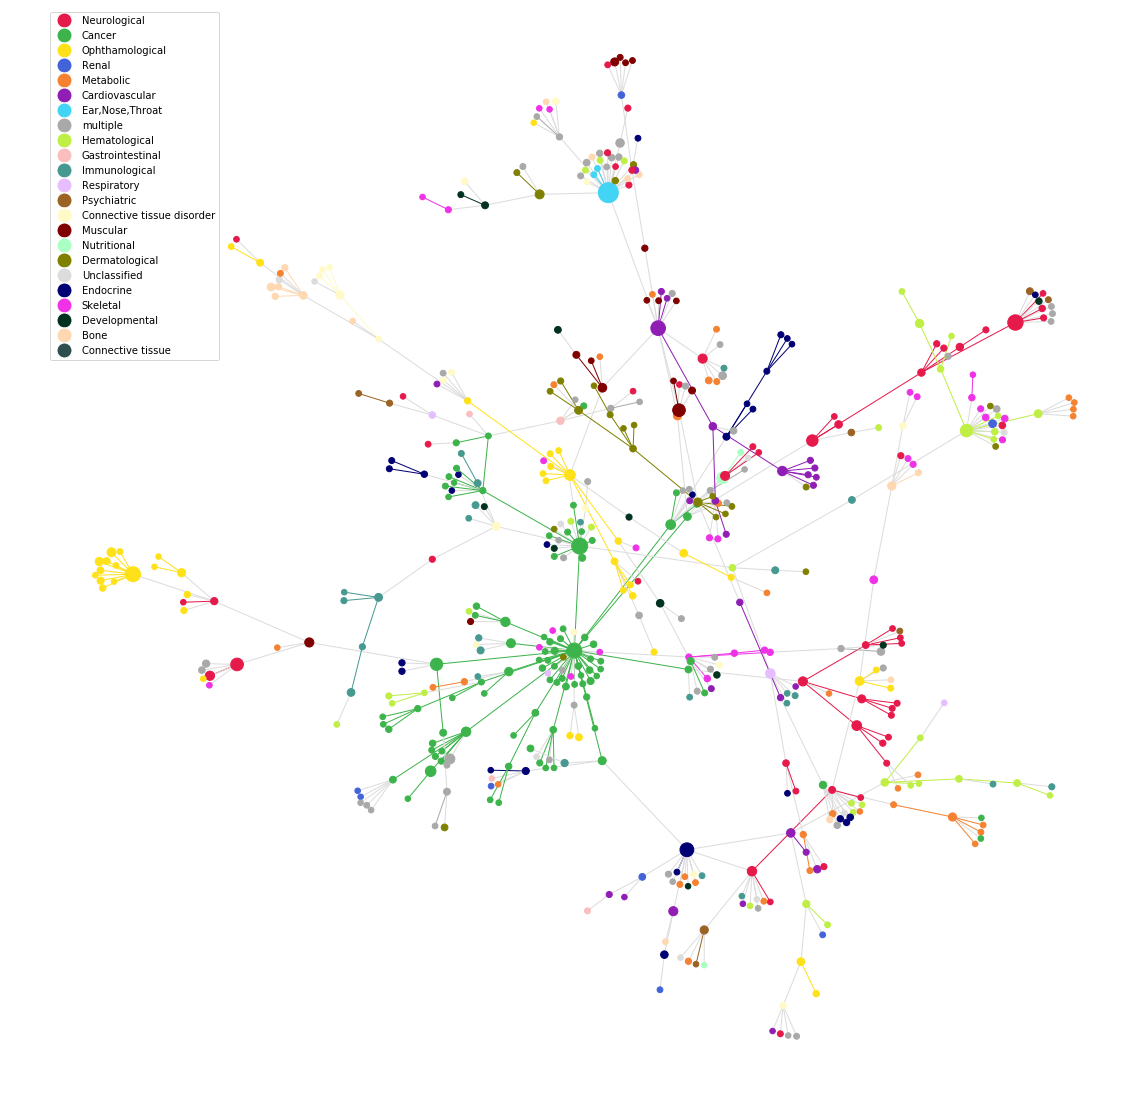

In [81]:
plotGraph(breadthFirstTraversal(G_disease, False), "Class")

In [103]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

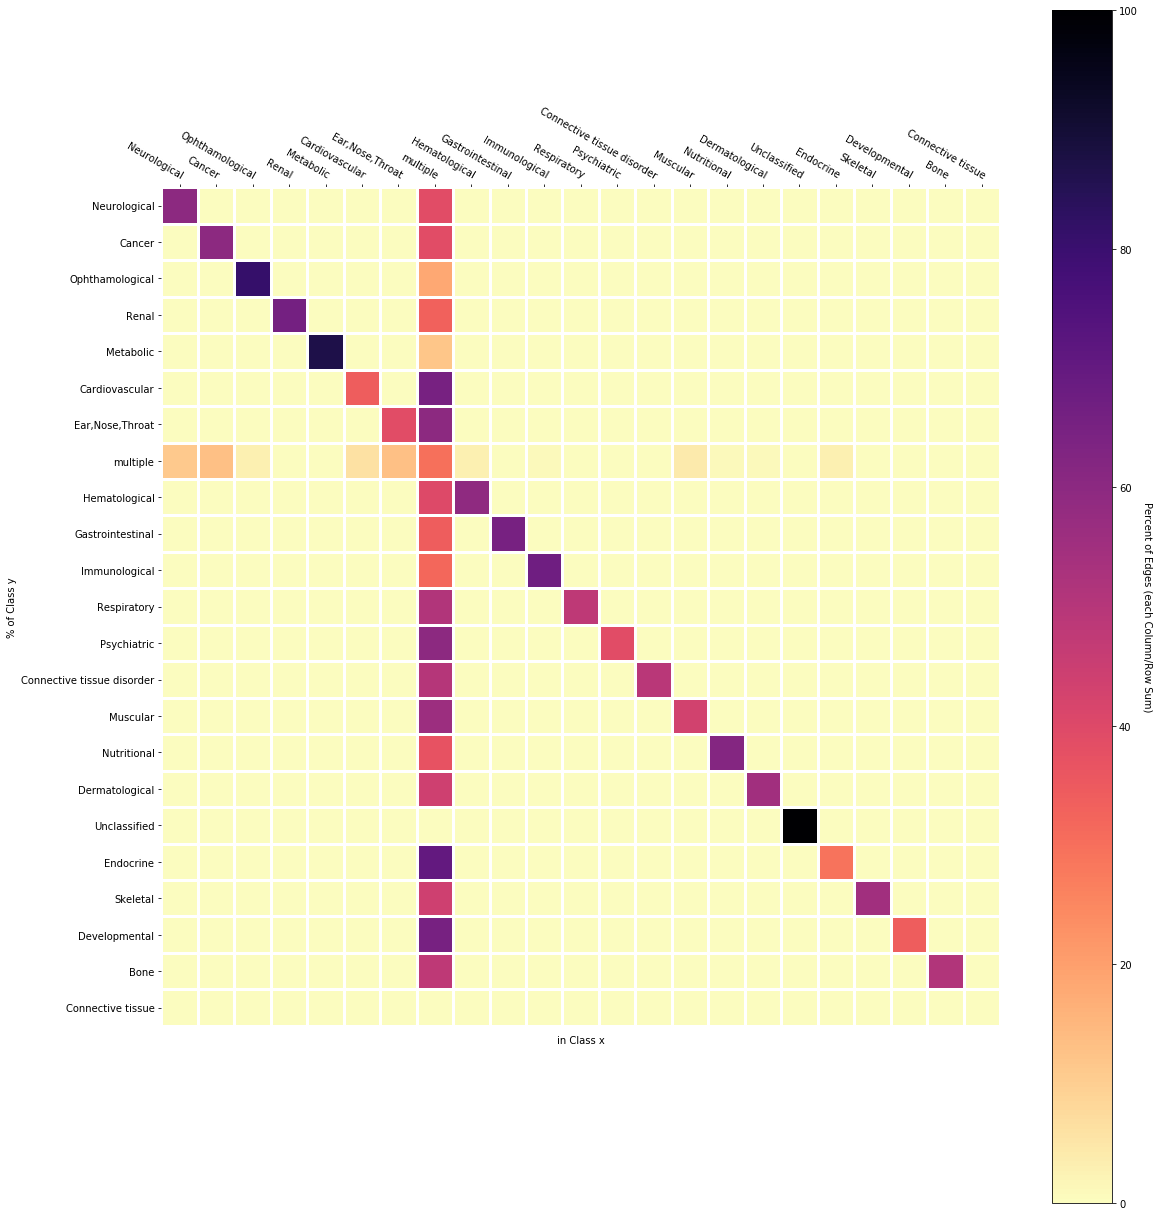

In [187]:
fig = plt.subplots(1, 1, figsize=(17, 17))

GT = G_gene

y = unique_class
x = unique_class

data = np.zeros((len(y), len(y)),dtype=int)

for i,j in GT.edges():
    indexi = indices[GT.node[i]["Class"]]
    indexj = indices[GT.node[j]["Class"]]
    
    if indexi == indexj:
        data[indexi][indexj] = data[indexi][indexj] + 1
    else:
        data[indexi][indexj] = data[indexi][indexj] + 1
        data[indexj][indexi] = data[indexj][indexi] + 1

for i in range(len(data)):
    sumrow = np.sum(data[i])
    for j in range(len(data)):
        if sumrow != 0:
            data[i][j] = int(data[i][j]*100/sumrow)

    
im, _ = heatmap(data, y, x, vmin=0,
                cmap="magma_r", cbarlabel="Percent of Edges (each Column/Row Sum)")
# annotate_heatmap(im, valfmt="{x:d}", size=12, threshold=20,
#                  textcolors=["red", "white"])

plt.ylabel("% of Class y")

plt.xlabel("in Class x")
plt.tight_layout()
plt.show()

In [1]:
fig = plt.subplots(1, 1, figsize=(17, 17))

GT = G_disease

y = unique_class
x = unique_class

data = np.zeros((len(y), len(y)),dtype=int)

for i,j in GT.edges():
    indexi = indices[GT.node[i]["Class"]]
    indexj = indices[GT.node[j]["Class"]]
    
    if indexi == indexj:
        data[indexi][indexj] = data[indexi][indexj] + 1
    else:
        data[indexi][indexj] = data[indexi][indexj] + 1
        data[indexj][indexi] = data[indexj][indexi] + 1

for i in range(len(data)):
    sumrow = np.sum(data[i])
    for j in range(len(data)):
        if sumrow != 0:
            data[i][j] = int(data[i][j]*100/sumrow)

    
im, _ = heatmap(data, y, x, vmin=0,
                cmap="magma_r", cbarlabel="Percent of Edges (each Column/Row Sum)")
# annotate_heatmap(im, valfmt="{x:d}", size=12, threshold=20,
#                  textcolors=["red", "white"])

plt.ylabel("% of Class y")

plt.xlabel("in Class x")
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined